# Import Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys


sys.path.append('../analysis_scripts')

In [4]:
data_oc_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_signal.csv')
data_mb_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_background.csv')

In [5]:
data_oc_df = data_oc_df.drop(['n_event'], axis=1)
mass_mask = (data_oc_df['mass_Lc'] > 2.24763) & ( data_oc_df['mass_Lc'] < 2.32497) & (data_oc_df['true_decay'] == 1)
data_oc_df = data_oc_df[mass_mask]
data_oc_df['tag'] = 'Sig'

data_mb_df = data_mb_df.drop(['n_event'], axis=1)
mass_mask = (data_mb_df['mass_Lc'] > 2.24763) & ( data_mb_df['mass_Lc'] < 2.32497)
data_mb_df = data_mb_df[mass_mask]
data_mb_df['tag'] = 'Bg'

raw_df = pd.concat([data_oc_df, data_mb_df], axis=0).reset_index(drop=True)

raw_df['cosAngle_r_Lc_momentum_Lc'] = raw_df['cosAngle_r_Lc_momentum_Lc'].apply(np.cos)
raw_df['cosAngle_r_Lc_sum_momentum'] = raw_df['cosAngle_r_Lc_sum_momentum'].apply(np.cos)
raw_df['cosAngle_momentum_Lc_sum_momentum'] = raw_df['cosAngle_momentum_Lc_sum_momentum'].apply(np.cos)

raw_df['cosAngle_r_Lc_momentum_Lc_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc'] < 0, 'cosAngle_r_Lc_momentum_Lc']
raw_df['cosAngle_r_Lc_momentum_Lc_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc'] > 0, 'cosAngle_r_Lc_momentum_Lc']

raw_df['cosAngle_r_Lc_sum_momentum_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum'] < 0, 'cosAngle_r_Lc_sum_momentum']
raw_df['cosAngle_r_Lc_sum_momentum_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum'] > 0, 'cosAngle_r_Lc_sum_momentum']

# Preselection

In [ ]:
from selection_scripts import auto_preselection


proc_df = raw_df.copy()

feature_to_remove = ['mass_Lc', 'cosAngle_r_Lc_momentum_Lc', 'cosAngle_r_Lc_sum_momentum',
                     'phi_angle', 'multiplicity', 'Lc_diff_x', 'Lc_diff_y', 'Lc_diff_z',
                     'PV_diff_x', 'PV_diff_y', 'PV_diff_z', 'PV_diff_ES_x', 'PV_diff_ES_y',
                     'PV_diff_ES_z', 'true_decay', 'tag']

features_to_select = list(proc_df.columns)

for feature in feature_to_remove:
    features_to_select.remove(feature)

selection_df, mask = auto_preselection(
    df=proc_df,
    features=features_to_select,
    safety_interval=0.9,
    indent=2,
    quantile_left=1e-2,
    quantile_right=1-1e-2,
    recursive=True
)

proc_df = proc_df.query(mask)

# PV FIT

### PV x-axis

Fit problems!
Optimization result:
Success: False
Message: Maximum number of iterations has been exceeded.
Number of iterations: 1000
Final objective value: 138.796392
Gauss 1 parameters: A=8315.6378, mean=0.000006, sigma=0.003612
Gauss 2 parameters: A=1536.5848, mean=-0.000030, sigma=0.007406
Constant: C=0.0517
Effective Mean: 0.000000
Effective Sigma: 0.004423
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 19
Final objective value: 99.004908
Gauss 1 parameters: A=1891.5640, mean=-0.000029, sigma=0.006947
Gauss 2 parameters: A=8001.9418, mean=0.000010, sigma=0.003528
Constant: C=6.3233
Effective Mean: 0.000002
Effective Sigma: 0.004392


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(


Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 367
Final objective value: 26925.716036
Gauss 1 parameters: A=8.0195, mean=-77.278363, sigma=120.809777
Gauss 2 parameters: A=2613.6104, mean=-0.000011, sigma=0.006831
Constant: C=2.0146
Effective Mean: -0.236403
Effective Sigma: 6.681736
Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 66
Final objective value: 1599.185493
Gauss 1 parameters: A=740.2529, mean=-634.255321, sigma=42.041185
Gauss 2 parameters: A=9046.1248, mean=-0.000003, sigma=0.004445
Constant: C=14.6125
Effective Mean: -47.975805
Effective Sigma: 11.562561
Skip method: Newton-CG
Optimization result:
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Number of iterations: 64
Final objective value: 375.182359
Gauss 1 parameters: A=5009.3744, mean=-0.000026, sigma

/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method BFGS cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method Newton-CG cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(


Optimization result:
Success: True
Message: Return from COBYLA because the trust region radius reaches its lower bound.
Skip method: COBYLA
Fit problems!
Optimization result:
Success: False
Message: The maximum number of iterations has been exceeded
Number of iterations: 1000
Final objective value: 67513.431932
Gauss 1 parameters: A=28.2713, mean=-0.001019, sigma=0.015539
Gauss 2 parameters: A=26.5173, mean=-0.001329, sigma=0.016794
Constant: C=5.5302
Effective Mean: -0.001169
Effective Sigma: 0.016159
Optimization result:
Success: True
Message: Optimization terminated successfully
Number of iterations: 16
Final objective value: 58034.597247
Gauss 1 parameters: A=265.7131, mean=0.000946, sigma=0.010107
Gauss 2 parameters: A=276.2561, mean=0.005925, sigma=0.008317
Constant: C=19.1500
Effective Mean: 0.003484
Effective Sigma: 0.009238


/home/ome123/python_envs/gen_DA-env/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 430
Final objective value: 100.901831
Gauss 1 parameters: A=7796.4062, mean=0.000011, sigma=0.003461
Gauss 2 parameters: A=2102.2219, mean=-0.000030, sigma=0.006778
Constant: C=6.9162
Effective Mean: 0.000003
Effective Sigma: 0.004381
Skip method: dogleg
Skip method: trust-ncg
Skip method: trust-exact
Skip method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='trust-constr'


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method dogleg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-ncg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-exact cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-krylov cannot handle bounds.
  result = minimize(


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 430
Final objective value: 100.901831
Gauss 1 parameters: A=7796.4062, mean=0.000011, sigma=0.003461
Gauss 2 parameters: A=2102.2219, mean=-0.000030, sigma=0.006778
Constant: C=6.9162
Effective Mean: 0.000003
Effective Sigma: 0.004381


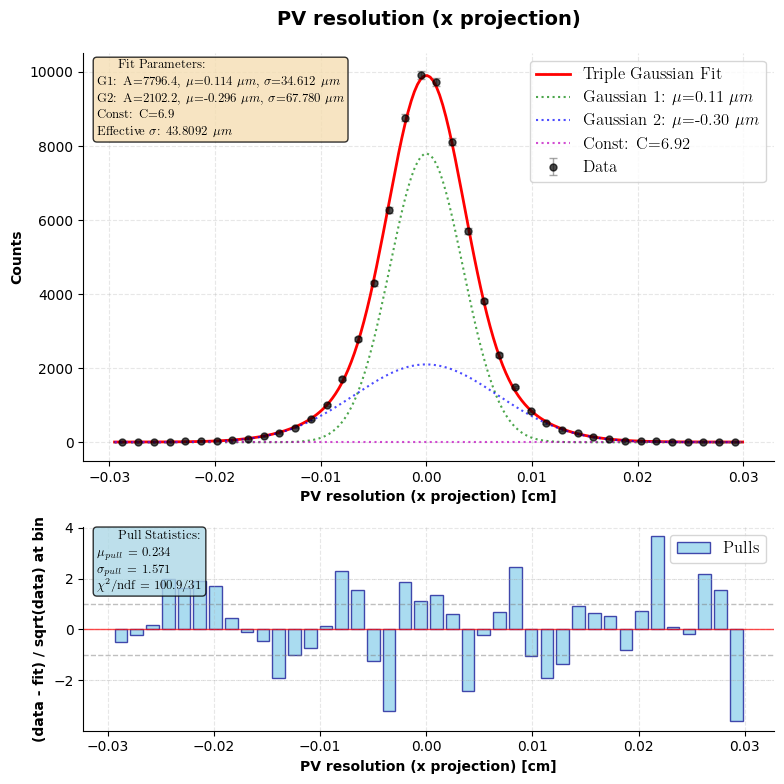

In [ ]:
# from scripts import fit_distr
from fit_scripts import fit_distr_double_gauss


# proc_df = raw_df.copy()

distr_name = 'PV_diff_ES_x'

sig_PV_df = proc_df.loc[proc_df['tag'] == 'Sig', distr_name].copy()

sig_PV_df_sel = sig_PV_df[abs(sig_PV_df) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    # if method in ('trust-constr', 'SLSQP'):
    #     continue

    try:
        result = fit_distr_double_gauss(
            distr=sig_PV_df_sel,
            distr_name=distr_name,
            title=distr_name,
            x_label=distr_name + ' [cm]',
            optimize_method=method,
            plot=False,
            bins=40
        )
    except:
        print(f'Skip method: {method}')
        continue
    
    if result.success and result.fun < min_loss:
        best_method = method
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=sig_PV_df_sel,
    distr_name=distr_name,
    title='PV resolution (x projection)',
    x_label='PV resolution (x projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000
)

plt.savefig(f'../plots/{distr_name}_Sig.pdf')

# PV y-axis

Fit problems!
Optimization result:
Success: False
Message: Maximum number of iterations has been exceeded.
Number of iterations: 1000
Final objective value: 196.563986
Gauss 1 parameters: A=1287.7385, mean=-0.000729, sigma=0.007568
Gauss 2 parameters: A=8565.8944, mean=0.000104, sigma=0.003677
Constant: C=0.3371
Effective Mean: -0.000005
Effective Sigma: 0.004386
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 24
Final objective value: 70.407877
Gauss 1 parameters: A=1998.8073, mean=-0.000062, sigma=0.006789
Gauss 2 parameters: A=7942.1988, mean=0.000027, sigma=0.003483
Constant: C=7.5886
Effective Mean: 0.000009
Effective Sigma: 0.004355


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(


Fit problems!
Optimization result:
Success: False
Message: Maximum number of iterations has been exceeded.
Number of iterations: 1000
Final objective value: 33270.813584
Gauss 1 parameters: A=1012.7684, mean=-0.000033, sigma=0.007245
Gauss 2 parameters: A=1013.9560, mean=-0.000033, sigma=-0.007245
Constant: C=7.0068
Effective Mean: -0.000033
Effective Sigma: 0.007245
Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 49
Final objective value: 1499.547781
Gauss 1 parameters: A=1526.3686, mean=69.792209, sigma=-19.670476
Gauss 2 parameters: A=9100.8331, mean=0.000004, sigma=0.004415
Constant: C=13.7155
Effective Mean: 10.024151
Effective Sigma: 7.454786
Skip method: Newton-CG
Optimization result:
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Number of iterations: 53
Final objective value: 327.636056
Gauss 1 parameters: A=5022.9684, mean=-0.000020, sigma=0.005386
Gauss

/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method BFGS cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method Newton-CG cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(


Fit problems!
Optimization result:
Success: False
Message: Max. number of function evaluations reached
Number of iterations: 18
Final objective value: 66755.990323
Gauss 1 parameters: A=43.3201, mean=-0.002431, sigma=0.014683
Gauss 2 parameters: A=43.4985, mean=-0.000133, sigma=0.018163
Constant: C=0.0068
Effective Mean: -0.001280
Effective Sigma: 0.016519
Optimization result:
Success: True
Message: Return from COBYLA because the trust region radius reaches its lower bound.
Skip method: COBYLA
Fit problems!
Optimization result:
Success: False
Message: The maximum number of iterations has been exceeded
Number of iterations: 1000
Final objective value: 66883.042934
Gauss 1 parameters: A=28.8368, mean=0.000206, sigma=0.012664
Gauss 2 parameters: A=41.0425, mean=0.000053, sigma=0.012562
Constant: C=14.4257
Effective Mean: 0.000116
Effective Sigma: 0.012604


/home/ome123/python_envs/gen_DA-env/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Fit problems!
Optimization result:
Success: False
Message: The maximum number of function evaluations is exceeded.
Number of iterations: 1000
Final objective value: 71.508793
Gauss 1 parameters: A=1860.2413, mean=-0.000067, sigma=0.006906
Gauss 2 parameters: A=8073.4304, mean=0.000026, sigma=0.003520
Constant: C=7.1010
Effective Mean: 0.000009
Effective Sigma: 0.004359
Skip method: dogleg
Skip method: trust-ncg
Skip method: trust-exact
Skip method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='L-BFGS-B'
Optimization result:
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Number of iterations: 53
Final objective value: 327.636056
Gauss 1 parameters: A=5022.9684, mean=-0.000020, sigma=0.005386
Gauss 2 parameters: A=5016.6068, mean=0.000046, 

/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method dogleg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-ncg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-exact cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-krylov cannot handle bounds.
  result = minimize(


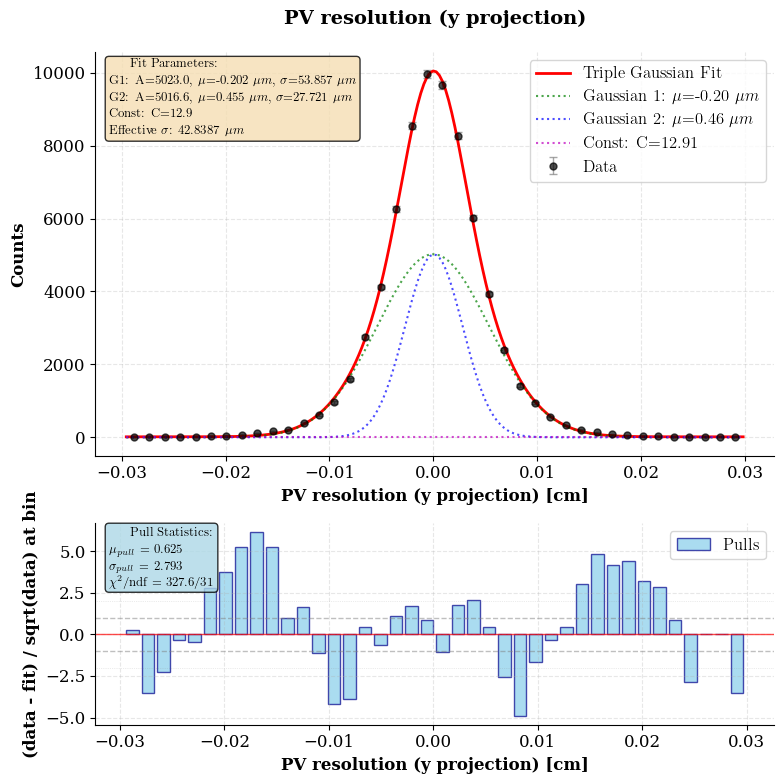

In [ ]:
from fit_scripts import fit_distr_double_gauss


# proc_df = raw_df.copy()

distr_name = 'PV_diff_ES_y'

sig_PV_df = proc_df.loc[proc_df['tag'] == 'Sig', distr_name].copy()

sig_PV_df_sel = sig_PV_df[abs(sig_PV_df) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    if method in ('SLSQP'):
        continue

    try:
        result = fit_distr_double_gauss(
            distr=sig_PV_df_sel,
            distr_name=distr_name,
            title=distr_name,
            x_label=distr_name + ' [cm]',
            optimize_method=method,
            plot=False,
            bins=40
        )
    except:
        print(f'Skip method: {method}')
        continue
    
    if result.success and result.fun < min_loss:
        best_method = method
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=sig_PV_df_sel,
    distr_name=distr_name,
    title='PV resolution (y projection)',
    x_label='PV resolution (y projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000
)

plt.savefig(f'../plots/{distr_name}_Sig.pdf')

# PV z-axis

Fit problems!
Optimization result:
Success: False
Message: Maximum number of iterations has been exceeded.
Number of iterations: 1000
Final objective value: 223.284040
Gauss 1 parameters: A=8037.8257, mean=0.000050, sigma=0.004254
Gauss 2 parameters: A=699.2033, mean=-0.000193, sigma=0.009814
Constant: C=2.2065
Effective Mean: 0.000031
Effective Sigma: 0.004935
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 33
Final objective value: 65.643882
Gauss 1 parameters: A=1780.2156, mean=-0.000079, sigma=0.007642
Gauss 2 parameters: A=7246.2799, mean=0.000023, sigma=0.003830
Constant: C=14.1996
Effective Mean: 0.000003
Effective Sigma: 0.004826


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(


Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 571
Final objective value: 30085.050104
Gauss 1 parameters: A=2064.6253, mean=-0.000034, sigma=-0.007871
Gauss 2 parameters: A=87.8127, mean=453.819047, sigma=316.018058
Constant: C=-16.3621
Effective Mean: 18.514361
Effective Sigma: 63.830065
Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 54
Final objective value: 1469.984681
Gauss 1 parameters: A=2318.2753, mean=-96.125415, sigma=11.208711
Gauss 2 parameters: A=8259.0737, mean=-0.000007, sigma=0.004852
Constant: C=32.9791
Effective Mean: -21.068155
Effective Sigma: 5.247469
Skip method: Newton-CG
Optimization result:
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Number of iterations: 69
Final objective value: 327.261211
Gauss 1 parameters: A=4555.9575, mean=-0.000065, s

/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method BFGS cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method Newton-CG cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(


Optimization result:
Success: True
Message: Return from COBYLA because the trust region radius reaches its lower bound.
Skip method: COBYLA
Fit problems!
Optimization result:
Success: False
Message: The maximum number of iterations has been exceeded
Number of iterations: 1000
Final objective value: 65866.382860
Gauss 1 parameters: A=34.3455, mean=-0.000459, sigma=0.014766
Gauss 2 parameters: A=32.4639, mean=-0.000130, sigma=0.014572
Constant: C=28.8245
Effective Mean: -0.000299
Effective Sigma: 0.014672
Optimization result:
Success: True
Message: Optimization terminated successfully
Number of iterations: 12
Final objective value: 62220.432815
Gauss 1 parameters: A=103.4391, mean=-0.000844, sigma=0.010659
Gauss 2 parameters: A=104.7768, mean=0.000978, sigma=0.010702
Constant: C=69.2413
Effective Mean: 0.000073
Effective Sigma: 0.010681


/home/ome123/python_envs/gen_DA-env/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 410
Final objective value: 75.677982
Gauss 1 parameters: A=2179.1337, mean=-0.000080, sigma=0.007248
Gauss 2 parameters: A=6845.9257, mean=0.000031, sigma=0.003712
Constant: C=16.8535
Effective Mean: 0.000004
Effective Sigma: 0.004810
Skip method: dogleg
Skip method: trust-ncg
Skip method: trust-exact
Skip method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='trust-constr'


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method dogleg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-ncg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-exact cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-krylov cannot handle bounds.
  result = minimize(


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 410
Final objective value: 75.677982
Gauss 1 parameters: A=2179.1337, mean=-0.000080, sigma=0.007248
Gauss 2 parameters: A=6845.9257, mean=0.000031, sigma=0.003712
Constant: C=16.8535
Effective Mean: 0.000004
Effective Sigma: 0.004810


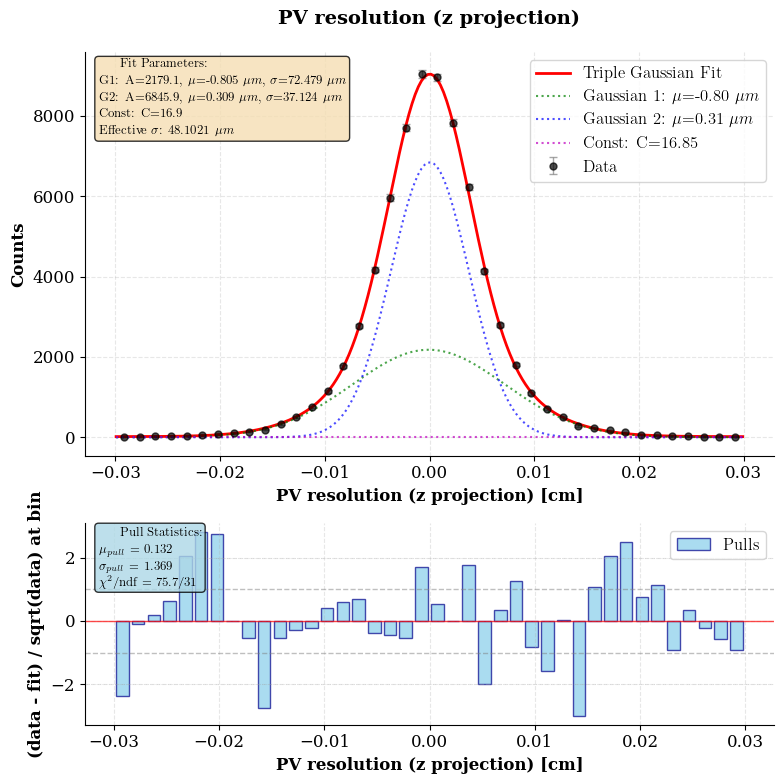

In [ ]:
from fit_scripts import fit_distr_double_gauss


# proc_df = raw_df.copy()

distr_name = 'PV_diff_ES_z'

sig_PV_df = proc_df.loc[proc_df['tag'] == 'Sig', distr_name].copy()

sig_PV_df_sel = sig_PV_df[abs(sig_PV_df) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    # if method in ('trust-constr', 'SLSQP'):
    #     continue

    try:
        result = fit_distr_double_gauss(
            distr=sig_PV_df_sel,
            distr_name=distr_name,
            title=distr_name,
            x_label=distr_name + ' [cm]',
            optimize_method=method,
            plot=False,
            bins=40
        )
    except:
        print(f'Skip method: {method}')
        continue
    
    if result.success and result.fun < min_loss:
        best_method = method
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=sig_PV_df_sel,
    distr_name=distr_name,
    title='PV resolution (z projection)',
    x_label='PV resolution (z projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000
)

plt.savefig(f'../plots/{distr_name}_Sig.pdf')

# SV FIT

# SV x-axis

Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 474
Final objective value: 63792.696834
Gauss 1 parameters: A=126.8517, mean=0.029240, sigma=0.029173
Gauss 2 parameters: A=130.0860, mean=-0.029105, sigma=0.029173
Constant: C=0.0000
Effective Mean: -0.000299
Effective Sigma: 0.029173
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 21
Final objective value: 35.296328
Gauss 1 parameters: A=2456.4246, mean=-0.000032, sigma=0.008698
Gauss 2 parameters: A=4635.0675, mean=-0.000010, sigma=0.004285
Constant: C=21.0767
Effective Mean: -0.000017
Effective Sigma: 0.006181


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1762: RuntimeWarning: invalid value encountered in sqrt
  effective_sigma = np.sqrt(effective_variance)
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method BFGS cannot handle bounds.
  result = minimize(


Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 192
Final objective value: 6960.726160
Gauss 1 parameters: A=3952.8694, mean=-0.000019, sigma=0.007598
Gauss 2 parameters: A=-33.4310, mean=238.292420, sigma=-36.460552
Constant: C=58.8209
Effective Mean: -2.032542
Effective Sigma: nan
Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 117
Final objective value: 1314.699182
Gauss 1 parameters: A=6290.9574, mean=-0.000017, sigma=0.006276
Gauss 2 parameters: A=-638.6034, mean=84.558750, sigma=17.025371
Constant: C=61.5990
Effective Mean: -9.553473
Effective Sigma: nan
Skip method: Newton-CG
Optimization result:
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Number of iterations: 55
Final objective value: 103.544114
Gauss 1 parameters: A=3559.4825, mean=-0.000026, sigma=0.007774


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1762: RuntimeWarning: invalid value encountered in sqrt
  effective_sigma = np.sqrt(effective_variance)
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method Newton-CG cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(


Optimization result:
Success: True
Message: Return from COBYLA because the trust region radius reaches its lower bound.
Skip method: COBYLA
Fit problems!
Optimization result:
Success: False
Message: The maximum number of iterations has been exceeded
Number of iterations: 1000
Final objective value: 58786.524610
Gauss 1 parameters: A=179.5627, mean=-0.000008, sigma=0.017208
Gauss 2 parameters: A=72.0574, mean=-0.000019, sigma=0.017206
Constant: C=8.8665
Effective Mean: -0.000011
Effective Sigma: 0.017207
Optimization result:
Success: True
Message: Optimization terminated successfully
Number of iterations: 10
Final objective value: 56480.532147
Gauss 1 parameters: A=162.3895, mean=0.000997, sigma=0.009637
Gauss 2 parameters: A=163.9993, mean=-0.007850, sigma=0.009640
Constant: C=115.6455
Effective Mean: -0.003448
Effective Sigma: 0.009639


/home/ome123/python_envs/gen_DA-env/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 572
Final objective value: 35.556801
Gauss 1 parameters: A=2525.0339, mean=-0.000032, sigma=0.008627
Gauss 2 parameters: A=4570.9456, mean=-0.000009, sigma=0.004247
Constant: C=22.2130
Effective Mean: -0.000017
Effective Sigma: 0.006173
Skip method: dogleg
Skip method: trust-ncg
Skip method: trust-exact
Skip method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='trust-constr'


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method dogleg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-ncg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-exact cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-krylov cannot handle bounds.
  result = minimize(


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 572
Final objective value: 35.556801
Gauss 1 parameters: A=2525.0339, mean=-0.000032, sigma=0.008627
Gauss 2 parameters: A=4570.9456, mean=-0.000009, sigma=0.004247
Constant: C=22.2130
Effective Mean: -0.000017
Effective Sigma: 0.006173


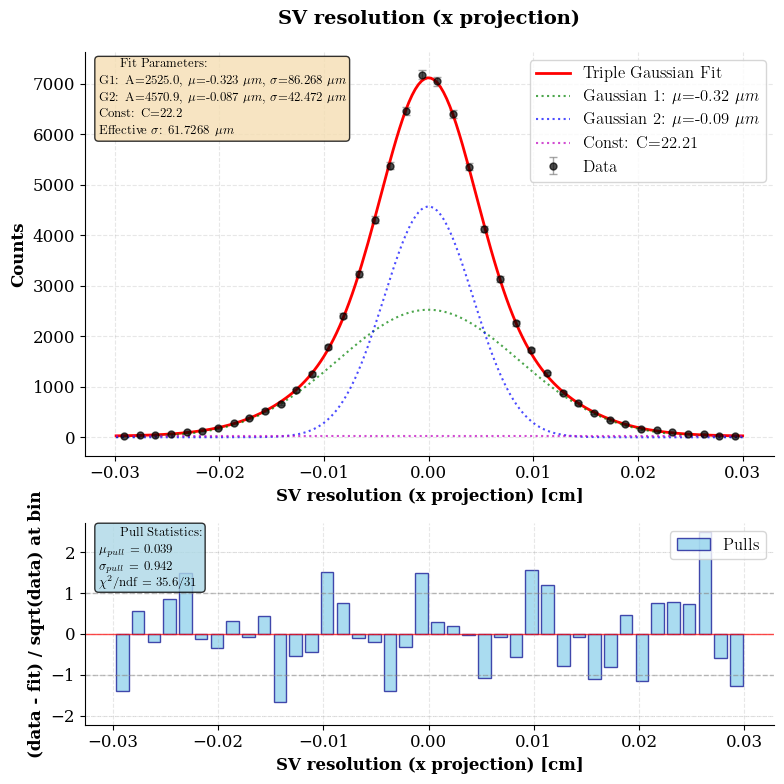

In [ ]:
# from scripts import fit_distr
from fit_scripts import fit_distr_double_gauss


# proc_df = raw_df.copy()

distr_name = 'Lc_diff_x'

sig_PV_df = proc_df.loc[proc_df['tag'] == 'Sig', distr_name].copy()

sig_PV_df_sel = sig_PV_df[abs(sig_PV_df) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    # if method in ('trust-constr', 'SLSQP'):
    #     continue

    try:
        result = fit_distr_double_gauss(
            distr=sig_PV_df_sel,
            distr_name=distr_name,
            title=distr_name,
            x_label=distr_name + ' [cm]',
            optimize_method=method,
            plot=False,
            bins=40
        )
    except:
        print(f'Skip method: {method}')
        continue
    
    if result.success and result.fun < min_loss:
        best_method = method
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=sig_PV_df_sel,
    distr_name=distr_name,
    title='SV resolution (x projection)',
    x_label='SV resolution (x projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000
)

plt.savefig(f'../plots/{distr_name}.pdf')

# PV y-axis

Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 433
Final objective value: 63501.820860
Gauss 1 parameters: A=142.2662, mean=0.029185, sigma=0.029167
Gauss 2 parameters: A=125.2129, mean=-0.029149, sigma=0.029167
Constant: C=0.0000
Effective Mean: 0.001878
Effective Sigma: 0.029167
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 21
Final objective value: 43.615195
Gauss 1 parameters: A=2748.5423, mean=-0.000029, sigma=0.008297
Gauss 2 parameters: A=4414.7824, mean=0.000018, sigma=0.004117
Constant: C=29.6370
Effective Mean: -0.000000
Effective Sigma: 0.006071


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(


Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 228
Final objective value: 18177.461924
Gauss 1 parameters: A=2529.7284, mean=-0.000005, sigma=0.008510
Gauss 2 parameters: A=173.8033, mean=-143.078819, sigma=-21.810578
Constant: C=73.3277
Effective Mean: -9.198186
Effective Sigma: 5.530074
Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 35
Final objective value: 1222.913247
Gauss 1 parameters: A=921.4848, mean=50.408709, sigma=12.414857
Gauss 2 parameters: A=6347.5105, mean=-0.000015, sigma=0.006211
Constant: C=64.8569
Effective Mean: 6.390259
Effective Sigma: 4.420272
Skip method: Newton-CG
Optimization result:
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Number of iterations: 16
Final objective value: 61174.189912
Gauss 1 parameters: A=50.8423, mean=0.000153, sigma=0

/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method BFGS cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method Newton-CG cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(


Optimization result:
Success: True
Message: Return from COBYLA because the trust region radius reaches its lower bound.
Skip method: COBYLA
Fit problems!
Optimization result:
Success: False
Message: The maximum number of iterations has been exceeded
Number of iterations: 1000
Final objective value: 58484.654934
Gauss 1 parameters: A=104.9300, mean=0.000208, sigma=0.013863
Gauss 2 parameters: A=106.8614, mean=0.000237, sigma=0.013872
Constant: C=73.3293
Effective Mean: 0.000223
Effective Sigma: 0.013868
Optimization result:
Success: True
Message: Optimization terminated successfully
Number of iterations: 13
Final objective value: 42695.743674
Gauss 1 parameters: A=724.8774, mean=0.004914, sigma=0.009491
Gauss 2 parameters: A=745.5528, mean=0.004525, sigma=0.012120
Constant: C=76.8679
Effective Mean: 0.004717
Effective Sigma: 0.010904


/home/ome123/python_envs/gen_DA-env/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 489
Final objective value: 44.912599
Gauss 1 parameters: A=4563.0343, mean=0.000014, sigma=0.004211
Gauss 2 parameters: A=2582.6553, mean=-0.000027, sigma=0.008445
Constant: C=27.3516
Effective Mean: -0.000001
Effective Sigma: 0.006091
Skip method: dogleg
Skip method: trust-ncg
Skip method: trust-exact
Skip method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='trust-constr'


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method dogleg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-ncg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-exact cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-krylov cannot handle bounds.
  result = minimize(


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 489
Final objective value: 44.912599
Gauss 1 parameters: A=4563.0343, mean=0.000014, sigma=0.004211
Gauss 2 parameters: A=2582.6553, mean=-0.000027, sigma=0.008445
Constant: C=27.3516
Effective Mean: -0.000001
Effective Sigma: 0.006091


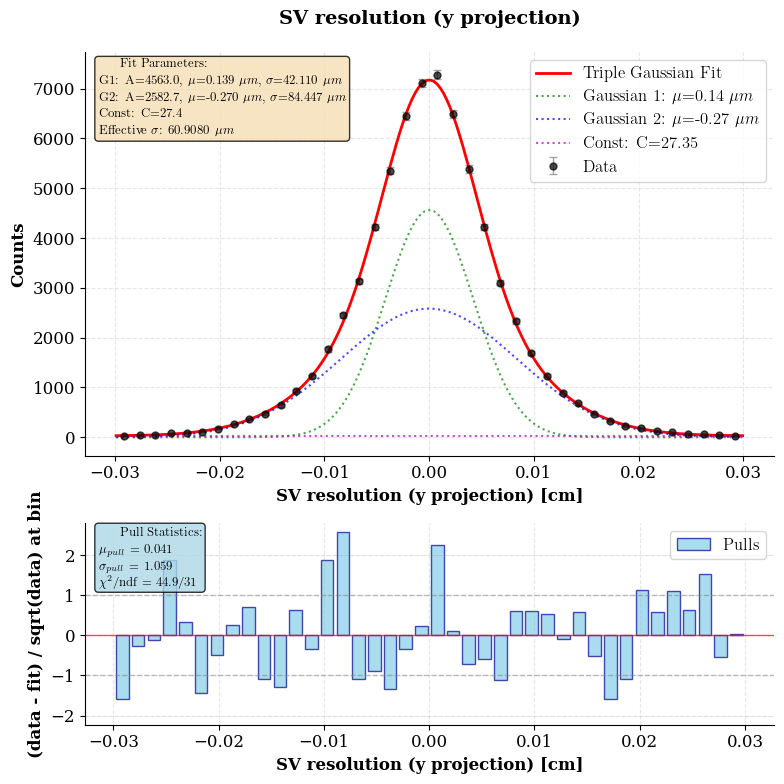

In [ ]:
# from scripts import fit_distr
from fit_scripts import fit_distr_double_gauss


# proc_df = raw_df.copy()

distr_name = 'Lc_diff_y'

sig_PV_df = proc_df.loc[proc_df['tag'] == 'Sig', distr_name].copy()

sig_PV_df_sel = sig_PV_df[abs(sig_PV_df) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    # if method in ('trust-constr', 'SLSQP'):
    #     continue

    try:
        result = fit_distr_double_gauss(
            distr=sig_PV_df_sel,
            distr_name=distr_name,
            title=distr_name,
            x_label=distr_name + ' [cm]',
            optimize_method=method,
            plot=False,
            bins=40
        )
    except:
        print(f'Skip method: {method}')
        continue
    
    if result.success and result.fun < min_loss:
        best_method = method
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=sig_PV_df_sel,
    distr_name=distr_name,
    title='SV resolution (y projection)',
    x_label='SV resolution (y projection)' + ' [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000
)

plt.savefig(f'../plots/{distr_name}.pdf')

# PV z-axis

Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 487
Final objective value: 55121.846210
Gauss 1 parameters: A=429.7035, mean=0.000923, sigma=0.029237
Gauss 2 parameters: A=0.0000, mean=-0.029247, sigma=0.029237
Constant: C=0.0000
Effective Mean: 0.000923
Effective Sigma: 0.029237
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 21
Final objective value: 26.492393
Gauss 1 parameters: A=2349.3876, mean=-0.000062, sigma=0.009119
Gauss 2 parameters: A=4413.9971, mean=-0.000025, sigma=0.004323
Constant: C=50.0910
Effective Mean: -0.000038
Effective Sigma: 0.006410


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1762: RuntimeWarning: invalid value encountered in sqrt
  effective_sigma = np.sqrt(effective_variance)
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method BFGS cannot handle bounds.
  result = minimize(


Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 206
Final objective value: 7412.798709
Gauss 1 parameters: A=-10.1247, mean=240.845198, sigma=41.317389
Gauss 2 parameters: A=3613.5926, mean=-0.000048, sigma=0.007875
Constant: C=116.1746
Effective Mean: -0.676752
Effective Sigma: nan
Fit problems!
Optimization result:
Success: False
Message: Desired error not necessarily achieved due to precision loss.
Number of iterations: 55
Final objective value: 1264.778226
Gauss 1 parameters: A=1304.3687, mean=21.516352, sigma=4.115186
Gauss 2 parameters: A=5973.2046, mean=-0.000043, sigma=0.006398
Constant: C=114.0573
Effective Mean: 3.856368
Effective Sigma: 1.742203
Skip method: Newton-CG
Optimization result:
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Number of iterations: 15
Final objective value: 55831.576063
Gauss 1 parameters: A=76.4635, mean=0.000073, sigma=0.01070

/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method Newton-CG cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(


Optimization result:
Success: True
Message: Return from COBYLA because the trust region radius reaches its lower bound.
Skip method: COBYLA
Fit problems!
Optimization result:
Success: False
Message: The maximum number of iterations has been exceeded
Number of iterations: 1000
Final objective value: 55810.725880
Gauss 1 parameters: A=145.3311, mean=0.000279, sigma=0.018965
Gauss 2 parameters: A=110.9954, mean=0.000271, sigma=0.018969
Constant: C=48.8849
Effective Mean: 0.000276
Effective Sigma: 0.018967
Optimization result:
Success: True
Message: Optimization terminated successfully
Number of iterations: 12
Final objective value: 32732.948308
Gauss 1 parameters: A=1526.7121, mean=-0.000391, sigma=0.011270
Gauss 2 parameters: A=1527.2432, mean=-0.000216, sigma=0.011270
Constant: C=166.7133
Effective Mean: -0.000303
Effective Sigma: 0.011270


/home/ome123/python_envs/gen_DA-env/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 445
Final objective value: 26.745924
Gauss 1 parameters: A=4355.7180, mean=-0.000024, sigma=0.004286
Gauss 2 parameters: A=2410.7135, mean=-0.000062, sigma=0.009041
Constant: C=51.7807
Effective Mean: -0.000037
Effective Sigma: 0.006399
Skip method: dogleg
Skip method: trust-ncg
Skip method: trust-exact
Skip method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='trust-constr'


/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method dogleg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-ncg cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-exact cannot handle bounds.
  result = minimize(
/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:1778: RuntimeWarning: Method trust-krylov cannot handle bounds.
  result = minimize(


Optimization result:
Success: True
Message: `xtol` termination condition is satisfied.
Number of iterations: 445
Final objective value: 26.745924
Gauss 1 parameters: A=4355.7180, mean=-0.000024, sigma=0.004286
Gauss 2 parameters: A=2410.7135, mean=-0.000062, sigma=0.009041
Constant: C=51.7807
Effective Mean: -0.000037
Effective Sigma: 0.006399


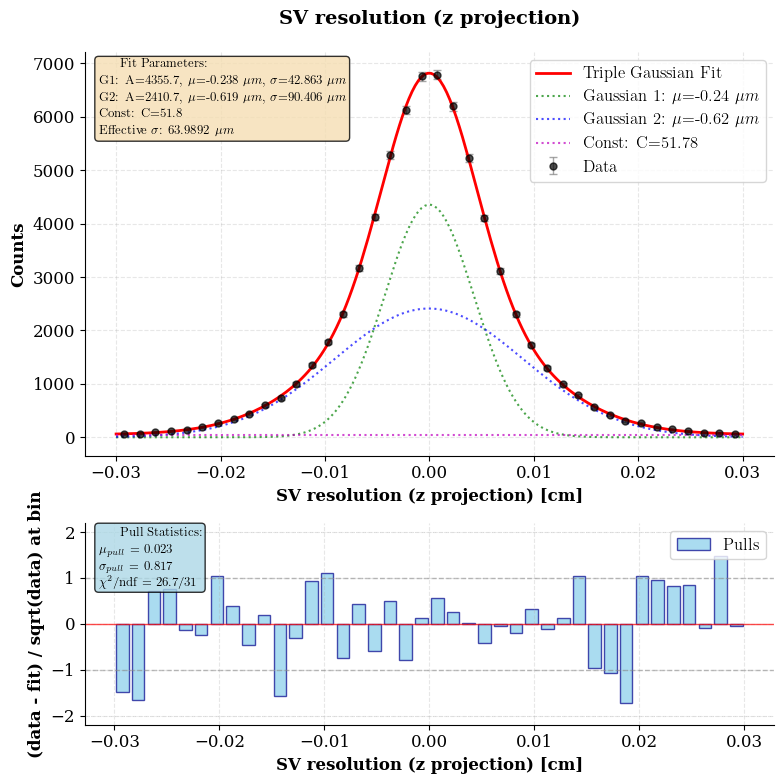

In [ ]:
# from scripts import fit_distr
from fit_scripts import fit_distr_double_gauss


# proc_df = raw_df.copy()

distr_name = 'Lc_diff_z'

sig_PV_df = proc_df.loc[proc_df['tag'] == 'Sig', distr_name].copy()

sig_PV_df_sel = sig_PV_df[abs(sig_PV_df) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    # if method in ('trust-constr', 'SLSQP'):
    #     continue

    try:
        result = fit_distr_double_gauss(
            distr=sig_PV_df_sel,
            distr_name=distr_name,
            title=distr_name,
            x_label=distr_name + ' [cm]',
            optimize_method=method,
            plot=False,
            bins=40
        )
    except:
        print(f'Skip method: {method}')
        continue
    
    if result.success and result.fun < min_loss:
        best_method = method
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=sig_PV_df_sel,
    distr_name=distr_name,
    title='SV resolution (z projection)',
    x_label='SV resolution (z projection)' + ' [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000
)

plt.savefig(f'../plots/{distr_name}.pdf')

# Background fit

<Axes: >

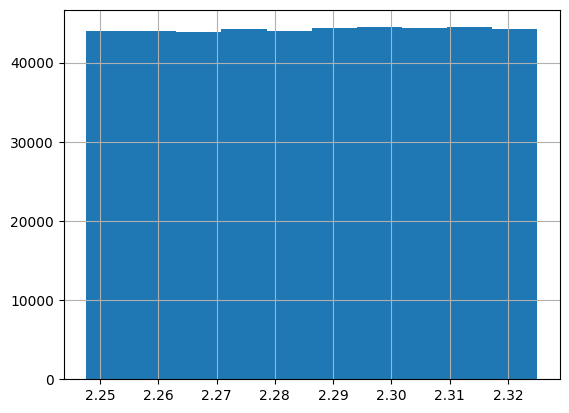

In [14]:
raw_df.loc[raw_df.tag == 'Bg', 'mass_Lc'].hist()